In this notebook, some image feature is introduced. And i will give some insight and product method in shopee compte. If you find usefule, please give upvote, thx.

image feature:
* image hash
* image color hist
* image keypint
* **image cnn fearure**, most accurate 


在本个notebook中，介绍了一些图片特征提取方法。我也会在介绍使用的同时，结合shopee比赛给出一些建议。如果你感谢内容对你有帮助，请给我点赞，谢谢。


You can check my other notebooks:

- [Shopee Products Matching: Image Part [English+中文]](https://www.kaggle.com/finlay/shopee-products-matching-image-part-english)
- [Shopee Products Matching: Text Part [English+中文]](https://www.kaggle.com/finlay/shopee-products-matching-text-part-english)
- [Shopee Products Matching: BoF Part [English+中文]](https://www.kaggle.com/finlay/shopee-products-matching-bof-part-english)
- [Shopee Products Matching: Augment Part [English中文]](https://www.kaggle.com/finlay/shopee-products-matching-augment-part-english)
- [[Unsupervised] Image + Text Baseline in 20min](https://www.kaggle.com/finlay/unsupervised-image-text-baseline-in-20min)



In [ ]:
DATA_PATH = '../input/shopee-product-matching/'

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2, matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import gc

train = pd.read_csv(DATA_PATH + 'train.csv')
train['image'] = DATA_PATH + 'train_images/' + train['image']
tmp = train.groupby('label_group').posting_id.agg('unique').to_dict()
train['target'] = train.label_group.map(tmp)

In [ ]:
train = train.sort_values(by='label_group')
train.head()

# 1 Image Hash

https://github.com/jenssegers/imagehash


four different hash method:
* average hashing (aHash)
* perception hashing (pHash)
* difference hashing (dHash)
* wavelet hashing (wHash)



In [ ]:
import imagehash
from PIL import Image

In [ ]:
ahash = imagehash.average_hash(Image.open(train['image'].iloc[0]))
ahash

In [ ]:
# conver to string
str(ahash)

In [ ]:
print(str(imagehash.average_hash(Image.open(train['image'].iloc[0]))))
print(str(imagehash.phash(Image.open(train['image'].iloc[0]))))
print(str(imagehash.dhash(Image.open(train['image'].iloc[0]))))
print(str(imagehash.whash(Image.open(train['image'].iloc[0]))))

image hash can calculate the distance by char edit distance. in below example, the hashs of sample group are differenet in some char.

相似图片的哈希值也有可能是相似的，因此可以考虑用编辑距离来衡量。

In [ ]:
print(str(imagehash.average_hash(Image.open(train['image'].iloc[0]))))
print(str(imagehash.average_hash(Image.open(train['image'].iloc[1]))))
print(str(imagehash.average_hash(Image.open(train['image'].iloc[2]))))

# 2 Color Hist

https://en.wikipedia.org/wiki/Color_histogram

color histogram is a representation of the distribution of colors in an image. For digital images, a color histogram represents the number of pixels that have colors in each of a fixed list of color ranges, that span the image's color space, the set of all possible colors.

颜色直方图统计的是图像中颜色取值的计数信息，如果图像颜色相似则颜色直方图相似。

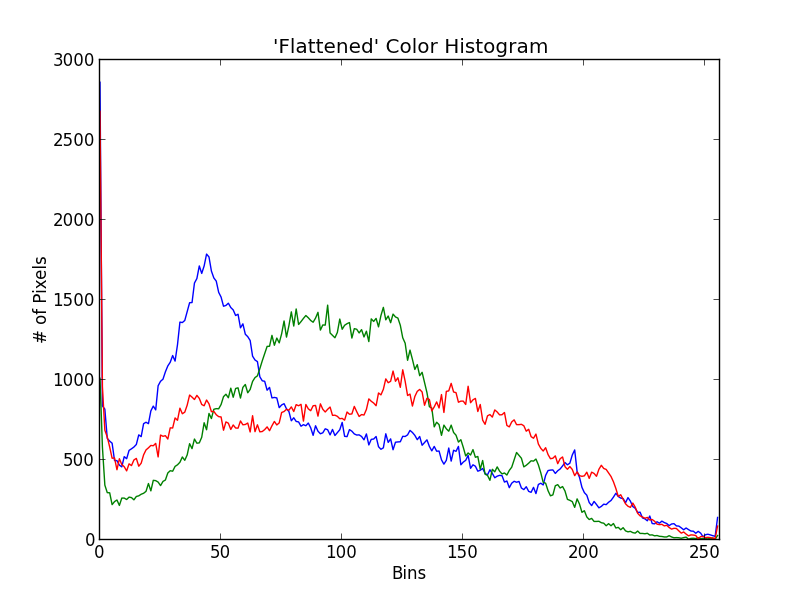

In [ ]:
img = cv2.imread(train['image'].iloc[0],0)

# https://docs.opencv.org/master/d1/db7/tutorial_py_histogram_begins.html
arr = cv2.calcHist([img],[0],None,[256],[0,256])
arr = arr.reshape(-1)
arr.shape

In [ ]:
%pylab inline
plt.plot(range(256), arr)

color hist can calculate the distance by array distance. in below example, the hist of sample group are very similar.

In [ ]:
def cal_hist(path):
    img = cv2.imread(path,0)
    arr = cv2.calcHist([img],[0],None,[256],[0,256])
    arr = arr.reshape(-1)
    return arr / arr.sum()

plt.plot(range(256), cal_hist(train['image'].iloc[0]))
plt.plot(range(256), cal_hist(train['image'].iloc[2]))

# 3 Image Keypoint

Keypoint is a feature detection algorithm in computer vision to detect and describe local features in images. SIFT and ORB is common keypoint method, you can find they in OpenCV.

Keypoint is a local image feature, so count of keypoint may not same. And keypoint is easy attract by text in image.

图像关键点是一种局部特征，所以不同图像有可能关键点不同，且关键点容易受图像中文字的影响。

https://en.wikipedia.org/wiki/Scale-invariant_feature_transform
https://docs.opencv.org/master/dc/dc3/tutorial_py_matcher.html

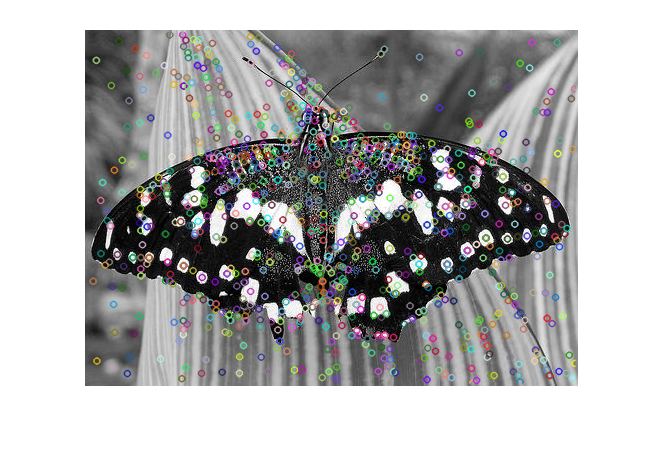

In [ ]:
img1 = cv2.imread(train['image'].iloc[0], 0)          # queryImage
img2 = cv2.imread(train['image'].iloc[2], 0)          # trainImage

# Initiate SIFT detector
sift = cv2.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

# BFMatcher with default params
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1,des2,k=2)

# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])

        # cv.drawMatchesKnn expects list of lists as matches.
img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,good,None,
                          flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(10, 7))
plt.imshow(img3),plt.show()


In [ ]:
img1 = cv2.imread(train['image'].iloc[0], 0)          # queryImage
img2 = cv2.imread(train['image'].iloc[1], 0)          # trainImage

# Initiate SIFT detector
sift = cv2.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

# BFMatcher with default params
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1,des2,k=2)

# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])

        # cv.drawMatchesKnn expects list of lists as matches.
img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,good,None,
                          flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(10, 7))
plt.imshow(img3),plt.show()


In [ ]:
# a function for sift distance
def sift_match(path1, path2):
    img1 = cv2.imread(path1, 0)
    img2 = cv2.imread(path2, 0)
    
    # Initiate SIFT detector
    sift = cv2.SIFT_create(300)
    
    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(img1,None)
    kp2, des2 = sift.detectAndCompute(img2,None)
    
    # BFMatcher with default params
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1,des2,k=2)
    # Apply ratio test
    good = []
    for m,n in matches:
        if m.distance < 0.8*n.distance:
            good.append([m])

    return len(good)

In [ ]:
# save group
sift_match(train[train['label_group'] == 249114794]['image'].iloc[0],
            train[train['label_group'] == 249114794]['image'].iloc[1])

In [ ]:
# different group
sift_match(train[train['label_group'] == 249114794]['image'].iloc[0],
            train[train['label_group'] == 258047]['image'].iloc[1])

# 4 Deep Convnet(CNN)

Deep learning can do many things, include image classification and detection. In shopee compte, we can use CNN to calcuate the image feature (the internal output of CNN models).

And we can use pretrain models or custom models (train in Shopee dataset by your self).

使用训练好的CNN来提取特征，是非常好的。当然你也可以在shopee比赛中自己训练数据集得到模型。

https://cs231n.github.io/convolutional-networks/

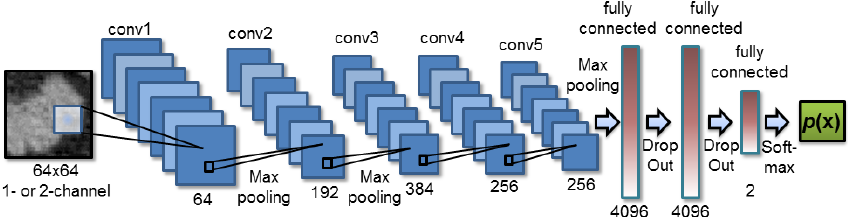

In [ ]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataset import Dataset

class ShopeeImageDataset(Dataset):
    def __init__(self, img_path, transform):
        self.img_path = img_path
        self.transform = transform
        
    def __getitem__(self, index):
        img = Image.open(self.img_path[index]).convert('RGB')
        img = self.transform(img)
        return img
    
    def __len__(self):
        return len(self.img_path)

In [ ]:
imagedataset = ShopeeImageDataset(
    train['image'].values[:100],
    transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]))
    
imageloader = torch.utils.data.DataLoader(
    imagedataset,
    batch_size=10, shuffle=False, num_workers=2
)

# pretrain models
class ShopeeImageEmbeddingNet(nn.Module):
    def __init__(self):
        super(ShopeeImageEmbeddingNet, self).__init__()
              
        model = models.resnet18(True)
        model.avgpool = nn.AdaptiveMaxPool2d(output_size=(1, 1))
        model = nn.Sequential(*list(model.children())[:-1])
        model.eval()
        self.model = model
        
    def forward(self, img):        
        out = self.model(img)
        return out

In [ ]:
DEVICE = 'cpu'

imgmodel = ShopeeImageEmbeddingNet()
imgmodel = imgmodel.to(DEVICE)

imagefeat = []
with torch.no_grad():
    for data in tqdm_notebook(imageloader):
        data = data.to(DEVICE)
        feat = imgmodel(data)
        feat = feat.reshape(feat.shape[0], feat.shape[1])
        feat = feat.data.cpu().numpy()
        
        imagefeat.append(feat)

In [ ]:
from sklearn.preprocessing import normalize

# l2 norm to kill all the sim in 0-1
imagefeat = np.vstack(imagefeat)
imagefeat = normalize(imagefeat)

In [ ]:
train.head(5)

In [ ]:
# in this case, the group 258047 (the first three) have high confidence.
np.dot(imagefeat[0], imagefeat.T)[:5]

In [ ]:
# in this case, the group 297977 (the last two) have high confidence.
np.dot(imagefeat[3], imagefeat.T)[:5]

# 6 Conclusion & Advice

1. **CNN feature is most accurate**, so i think you should spend more time in find beter CNN model.
    * You can try train model with arcface model in shopee compte data, then you will get a better image embedding.
    * You can train image matching or image classification.
    * You can try different pooing layer(max/mean/gem), these layers may give different result.
    * You can try different model architecture.
    * https://www.kaggle.com/ragnar123/unsupervised-baseline-arcface
    
2. You can find similar image by cnn feature, and re-order they by color hist and keypoint distance.
3. You can use external data to train model.
    * https://www.kaggle.com/lakritidis/product-clustering-matching-classification
    * https://www.kaggle.com/promptcloud/walmart-product-data-2019
    * https://www.kaggle.com/paramaggarwal/fashion-product-images-dataset
    * https://www.kaggle.com/mylee2009/shopee-round-2-product-detection-challenge    